# Stochastic Variational Inference
This script provides an implementation of stochastic variational inference. A variational distribution is fitted to approximate the true posterior distribution over a basic CNN's network parameters after having been trained on MNIST.

## Import some necessary packages

In [1]:
import tqdm
import torch
import numpy as np
import torch.nn as nn

from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from util.dataset import make_mnist
from model.vicnn import VICNN, ELBO
from torch.optim import Adam
from torch.utils.data import DataLoader
from util.util import show_images, run_model_on_data

## Building a variational CNN
In Bayesian Neural Network training we are interested in computing the posterior probability distribution after having seen some data. That is, by using Bayes theorem, we get
$$
p(z|D) = \frac{p(D|z)p(z)}{p(D)}
$$
where $z$ are network weights and biases, which are now considered random variables, and the data $D$. The term in the denominator $p(D)=\int p(D|z)p(z)dz$ is generally intractable and the main reason why Bayesian inference is hard.

The core idea of Stochastic Variational Inference is to learn a parameterized distribution $q(z)$ that approximates the posterior, i.e. $q(z) \sim p(z|D)$, and which is easier to sample from.

### Choosing a variational distribution
Let's choose the variational distribution $q(z)$ to be a distribution of the gaussian family, parametrized by $\mu$ and $\sigma$
$$
q_{\mu,\sigma}(z) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{(z - \mu)^2}{2\sigma^2} \right)
$$
Then, $\mu$ and $\sigma$ will be the parameters that we need to learn. We do **not** learn the network weights and biases directely anymore!

To set up a Neural Network for the Bayesian setting, we also need to define a prior distribution over our network weights and biases. As we don't have any prior knowledge at this point, we simply choose another Gaussian with zero mean and a constant standart deviation $\sigma_p$.
$$
p(z) = \mathcal{N}(0,\sigma_p) = \frac{1}{\sigma_p\sqrt{2\pi}} \exp\left( -\frac{z^2}{2\sigma_p^2} \right)
$$

### Reparametrization trick
Another peculiarity to consider here is that we cannot directly sample from the network weights $z$ if we still want to be able to pass gradients through the computational graph. Luckily, there is something known as the "Reparametrization Trick". Instead of sampling $z$ directly, we can equivalently sample $\epsilon$ from a Normal distribution, scale it by $\sigma$ and add it to $\mu$. 
$$
\begin{align*}
\epsilon \sim \mathcal{N}(0, 1) \\
z = \mu + \sigma \epsilon
\end{align*}
$$

In the following, a simple CNN with two convolutional and two linear layers is set up, where each layer is modified in a way to enable learning via stochastic variational inference. That is, learnable parameters are $\mu$ and $\sigma$ for a corresponding Gaussian distribution and the actual network weights are computed using above reparametrization trick. 

In [2]:
class MeanFieldGaussianLinear(nn.Module):
    def __init__(self, 
              in_features, 
              out_features, 
              init_sigma_w=1e-7,
              init_sigma_b=5e-7):
        super(MeanFieldGaussianLinear, self).__init__()
        
        # Weights
        self.mean_w = Parameter(torch.rand(out_features, in_features) - 0.5)
        self.sigma_w = Parameter(torch.log(init_sigma_w * torch.ones(out_features, in_features)))
        self.normal_w = Normal(torch.zeros(out_features, in_features), torch.ones(out_features, in_features))
        
        # Bias
        self.mean_b = Parameter(torch.rand(out_features) - 0.5)
        self.sigma_b = Parameter(torch.log(init_sigma_b * torch.ones(out_features)))
        self.normal_b = Normal(torch.zeros(out_features), torch.ones(out_features))
        
    def forward(self, x):
        # Sample weights
        epsilon_w = self.normal_w.sample().to(device=self.mean_w.device)
        self.z_w = self.mean_w + torch.exp(self.sigma_w) * epsilon_w
        
        # Sample bias
        epsilon_b = self.normal_b.sample().to(device=self.mean_b.device)
        self.z_b = self.mean_b + torch.exp(self.sigma_b) * epsilon_b

        return nn.functional.linear(x, self.z_w, bias=self.z_b)
    
    
class MeanFieldGaussianConv2d(nn.Module):
    def __init__(self,
              in_channels, 
              out_channels, 
              kernel_size, 
              init_sigma_w=1e-7, 
              init_sigma_b=5e-7):
        super(MeanFieldGaussianConv2d, self).__init__()
        
        # Weights
        self.mean_w = Parameter(torch.rand(out_channels, in_channels, kernel_size, kernel_size) - 0.5)
        self.sigma_w = Parameter(torch.log(init_sigma_w * torch.ones(out_channels, in_channels, kernel_size, kernel_size)))
        self.normal_w = Normal(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), 
                                   torch.ones(out_channels, in_channels, kernel_size, kernel_size))
        
        # Bias
        self.mean_b = Parameter(torch.rand(out_channels) - 0.5)
        self.sigma_b = Parameter(torch.log(init_sigma_b * torch.ones(out_channels)))
        self.normal_b = Normal(torch.zeros(out_channels), torch.ones(out_channels))
            
    def forward(self, x):
        # Sample weights
        epsilon_w = self.normal_w.sample().to(device=self.mean_w.device)
        self.z_w = self.mean_w + torch.exp(self.sigma_w) * epsilon_w
        
        # Sample bias
        epsilon_b = self.normal_b.sample().to(device=self.mean_b.device)
        self.z_b = self.mean_b + torch.exp(self.sigma_b) * epsilon_b
        
        return nn.functional.conv2d(x, self.z_w, bias=self.z_b)


class VICNN(nn.Module):
    def __init__(self, init_sigma_w=1e-7, init_sigma_b=5e-7):
        super().__init__()
        
        self.conv1 = MeanFieldGaussianConv2d(1, 16, kernel_size=5,
                                             init_sigma_w=init_sigma_w, 
                                             init_sigma_b=init_sigma_b)
        self.conv2 = MeanFieldGaussianConv2d(16, 32, kernel_size=5,
                                             init_sigma_w=init_sigma_w, 
                                             init_sigma_b=init_sigma_b)
        self.linear1 = MeanFieldGaussianLinear(512, 128,
                                             init_sigma_w=init_sigma_w, 
                                             init_sigma_b=init_sigma_b)
        self.linear2 = MeanFieldGaussianLinear(128, 10,
                                             init_sigma_w=init_sigma_w, 
                                             init_sigma_b=init_sigma_b)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))
        x = x.view(-1, 512)
        x = nn.functional.relu(self.linear1(x))
        
        x = self.linear2(x)
        return nn.functional.log_softmax(x, dim=-1)

## Derivation and implementation of the ELBO
The central idea of SVI is to learn a probability distribution $q(z)$ that approximates the true posterior $p(z|D)$. A good measure to quantify how close two distributions are is the Kullback Leibler divergence $KL$. We can thus start deriving the so called "Evidence Lower BOund" by writing out the KL divergence between our two distributions.
$$
\begin{align*}
KL\left(q(z)||p(z|D)\right) &= \int q(z)\log \left(\frac{q(z)}{p(z|D)}\right) dz \\
&= \int q(z)\log \left(\frac{q(z)p(D)}{p(D|z)p(z)}\right) dz \\
&= \int q(z)\log \left(\frac{q(z)}{p(D|z)p(z)}\right) dz  + \int q(z)\log p(D) dz \\
&= \int q(z)\log \left(\frac{q(z)}{p(D,z)}\right) dz  + \log p(D)\int q(z) dz \\
&= \int q(z)\log q(z) dz - \int q(z)\log p(D,z) dz + \log p(D) \\
&= \mathop{\mathbb{E}}_q\log q(z) - \mathop{\mathbb{E}}_q\log p(D,z) + \log p(D) \\
&= \log p(D) - ELBO(q)\\
\end{align*}
$$

The data likelihood $\log p(D)$ in above result is intractable. It is in fact the exact reason, why the computation of the posterior distribution is hard and we care about SVI in the first place. However, with respect to $q(z)$ it is just a constant value and therefore dropped when computing the respective gradients. So, in order to minimize $KL\left(q(z)||p(z|D)\right)$, we can instead maximize the $ELBO$, which can also be rewritten in the following way.
$$
\begin{align*}
ELBO(q) &= \mathop{\mathbb{E}}_q\log p(D,z) - \mathop{\mathbb{E}}_q\log q(z)  \\
&= \mathop{\mathbb{E}}_q\log p(D|z) + \mathop{\mathbb{E}}_q\log p(z) - \mathop{\mathbb{E}}_q\log q(z)  \\
&= \mathop{\mathbb{E}}_q\log p(D|z) - KL(q(z)||p(z))
\end{align*}
$$

## Defining the loss function
We want to maximize the ELBO. However, in order to make use of contemporary optimization packages, we minimize the negative ELBO instead. Since we are working with minibatches of data in the discrete setting, we formulate the loss as
$$
\mathcal{L} = -ELBO(q) = \sum_z \log q(z) - \sum_z \log p(z) - \frac{N}{M} \sum_M \log p(D_y|D_x,z) = \mathcal{L}_q + \mathcal{L}_p + \mathcal{L}_D
$$
with dataset size $N$ and mini-batch size $M$.

## Putting the loss together
Now, let's insert our chosen family of distributions for $q(z)$ and write out the individual loss terms as we will implement them later. Remember that we used the reparametrization trick to replace $z$.

$$
\begin{align*}
\mathcal{L} &= \mathcal{L}_p + \mathcal{L}_q + \mathcal{L}_D \\
\mathcal{L}_p &= -\log \left(\frac{1}{\sigma_p\sqrt{2\pi}} \exp\left( -\frac{z^2}{2\sigma_p^2} \right) \right) \\
&= -\log 1 + \log \left(\sigma_p\sqrt{2\pi}\right) - \log \exp\left( -\frac{z^2}{2\sigma_p^2} \right) \\
&= \log \sigma_p + \frac{\log (2\pi)}{2} + \frac{z^2}{2\sigma_p^2} \\

\mathcal{L}_q &= \log \left(\frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{(z - \mu)^2}{2\sigma^2} \right) \right) \\
&= \log \left(\frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{(\mu + \sigma \epsilon - \mu)^2}{2\sigma^2} \right) \right) \\
&= \log \left(\frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{\epsilon^2}{2} \right) \right) \\
&= -\log \sigma - \frac{\log (2\pi)}{2} - \frac{\epsilon^2}{2} \\

\mathcal{L}_D &= -\log p(D_y|D_x, z) \\
\end{align*}
$$

After removing all constants from these loss terms, we finally end up with
$$
\begin{align*}
\mathcal{L} &= \mathcal{L}_p + \mathcal{L}_q + \mathcal{L}_D \\
&= \frac{z^2}{2\sigma_p^2} - \log \sigma - \log p(D_y|D_x, z) \\
\end{align*}
$$

In [3]:
class ELBO():
    def __init__(self, variational_modules, dataset_size, prior_sigma_w=1.0, prior_sigma_b=5.0):
        self.variational_modules = variational_modules
        self.loss_D = torch.nn.NLLLoss(reduction='mean')
        self.dataset_size = dataset_size
        self.prior_sigma_w = prior_sigma_w
        self.prior_sigma_b = prior_sigma_b

    def loss_p(self, z, sigma_p):
        return 0.5 * z.pow(2).sum() / sigma_p**2
        
    def loss_q(self, sigma):
        return -sigma.sum()
        
    def __call__(self, pred, labels):
        loss = 0
        for module in self.variational_modules:
            # Weights loss
            loss += self.loss_p(module.z_w, self.prior_sigma_w)
            loss += self.loss_q(module.sigma_w)

            # Bias loss
            loss += self.loss_p(module.z_b, self.prior_sigma_b)
            loss += self.loss_q(module.sigma_b)
            
        # Negative loss likelihood
        loss += self.dataset_size * self.loss_D(pred, labels)
        return loss

## Train the model on MNIST
Let's train our variational model on the MNIST dataset. To show off some special feature of Bayesian Networks, we exclude a class from the train dataset and see later how the model reacts to it.

In [4]:
# Training settings
epochs = 10
lr = 5e-3
filtered_class = 5
batch_size = 64
train, test = make_mnist(filteredClass=filtered_class)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

# Initialize the model and set up ELBO as the loss function
model = VICNN()
elbo = ELBO([m for m in model.children() if hasattr(m, "mean_w")], len(train))
optimizer = Adam(model.parameters(), lr=lr)
optimizer.zero_grad()

# Start the training loop
for epoch in np.arange(epochs):
    for images, labels in (pbar := tqdm.tqdm(train_loader, total=len(train) // batch_size)):
        labels = torch.where(labels == 3, torch.randint(0, 10, labels.shape), labels)
        pred = model(images)
        loss = elbo(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"E={epoch} L={loss.detach():0.2f}")

E=0 L=992340.75: : 853it [00:09, 89.98it/s]                        
E=1 L=648125.62: : 853it [00:09, 88.12it/s]                       
E=2 L=287642.47: : 853it [00:09, 86.95it/s]                       
E=3 L=118742.12: : 853it [00:09, 87.83it/s]                       
E=4 L=109024.23: : 853it [00:10, 85.00it/s]                       
E=5 L=105939.82: : 853it [00:09, 85.69it/s]                       
E=6 L=95571.98: : 853it [00:10, 83.30it/s]                        
E=7 L=94329.05: : 853it [00:09, 87.65it/s]                        
E=8 L=85263.15: : 853it [00:09, 90.56it/s]                        
E=9 L=83539.53: : 853it [00:09, 90.13it/s]                        


## Visualize results
Let's run the network on some test data samples and see what predictive distributions it produces.

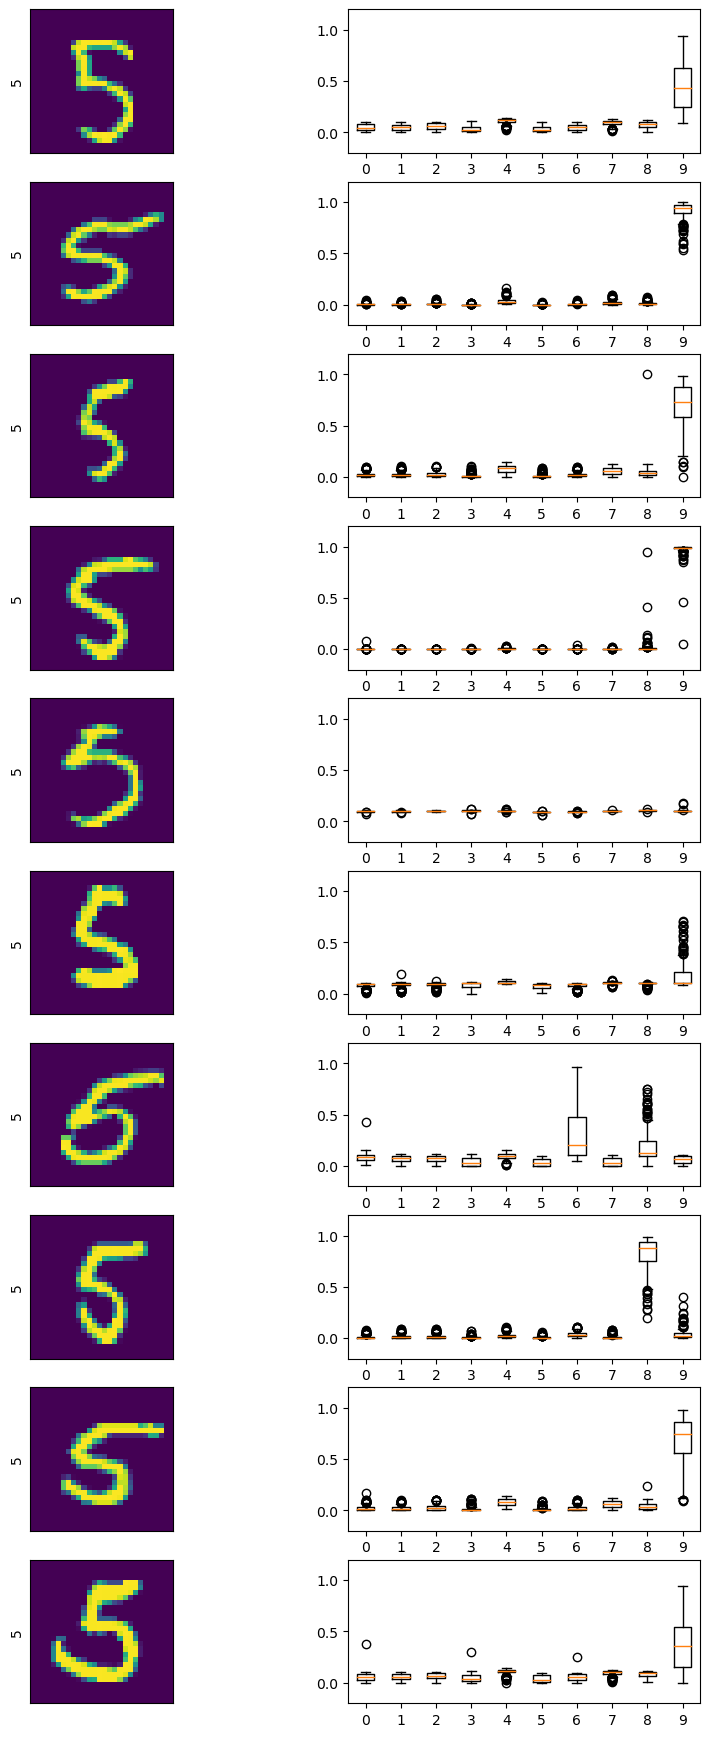

In [6]:
# Pick n test images and sample each num_samples times
# To select only a certain class, assign filter_class the corresponding number
num_images = 10
num_samples_per_image = 256
select_class = 5

_, test = make_mnist()
images, labels, samples = run_model_on_data(model, test, num_images, num_samples_per_image, select_class)

# Show images alongside Whisker plots
show_images(images, samples, labels)